Document Preprocessing and Embedding

In [1]:
import os 
import requests
pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print(f"[Info] File doesn't exist , downloading ...")
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    file_name = pdf_path
    response = requests.get(url)
    if response.status_code == 200 : 
        with open(file_name , "wb") as file  : 
            file.write(response.content)
        print(f"[INFO] the file has been downloaded and saved as {file_name}")
    else : 
        print(f"[INFO Failed to download the file . Status Code : {response.status_code} ]")
else : 
    print(f"[INFO] file already exists")

[INFO] file already exists


In [2]:
import fitz
from tqdm import tqdm

def text_formatter(text:str) -> str : 
    cleaned_text = text.replace("\n"," ").strip()
    return cleaned_text
def open_read_pdf(pdf_path:str)->list[dict] : 
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number , page in tqdm(enumerate(doc)) : 
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number" : page_number, 
                                "page_char_count" : len(text),                ## for exploratory data analysis
                                "page_word_count" : len(text.split(" ")),     ## for exploratory data analysis
                                "page_sentence_count" : len(text.split(".")), ## for exploratory data analysis
                                "page_token_count" : len(text)/4, ## every token consists of 4 chars              
                                "text":text})
        
    return pages_and_texts
pages_and_texts = open_read_pdf(pdf_path)
pages_and_texts[50]

1208it [00:01, 637.89it/s]


{'page_number': 50,
 'page_char_count': 1320,
 'page_word_count': 215,
 'page_sentence_count': 4,
 'page_token_count': 330.0,
 'text': 'Minerals  Major Functions  Macro  Sodium  Fluid balance, nerve transmission, muscle contraction  Chloride  Fluid balance, stomach acid production  Potassium  Fluid balance, nerve transmission, muscle contraction  Calcium  Bone and teeth health maintenance, nerve transmission,  muscle contraction, blood clotting  Phosphorus  Bone and teeth health maintenance, acid-base balance  Magnesium  Protein production, nerve transmission, muscle  contraction  Sulfur  Protein production  Trace  Iron  Carries oxygen, assists in energy production  Zinc  Protein and DNA production, wound healing, growth,  immune system function  Iodine  Thyroid hormone production, growth, metabolism  Selenium  Antioxidant  Copper  Coenzyme, iron metabolism  Manganese  Coenzyme  Fluoride  Bone and teeth health maintenance, tooth decay  prevention  Chromium  Assists insulin in glucose m

In [3]:
import pandas as pd 
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
0,0,29,4,1,7.25,Human Nutrition: 2020 Edition
1,1,0,1,1,0.00,
2,2,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,3,212,32,3,53.00,Human Nutrition: 2020 Edition by University of...
4,4,797,145,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [4]:
df.describe().round()

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.0,1208.0,1208.0,1208.0,1208.0
mean,604.0,1148.0,198.0,14.0,287.0
std,349.0,560.0,96.0,10.0,140.0
min,0.0,0.0,1.0,1.0,0.0
25%,302.0,762.0,134.0,8.0,190.0
50%,604.0,1232.0,214.0,13.0,308.0
75%,905.0,1604.0,271.0,19.0,401.0
max,1207.0,2308.0,429.0,82.0,577.0


Splitting pages into sentences

In [5]:
from spacy.lang.en import English
nlp = English()
## adding spacy sentencizer ==> split text into sentences (link to the doc : https://spacy.io/api/sentencizer)
sentencizer = nlp.add_pipe("sentencizer")
## doc instance for demonstration 
doc = nlp("this is a senteence . this is another one . A third one !")
assert len(list(doc.sents)) == 3
list(doc.sents)

[this is a senteence ., this is another one ., A third one !]

In [6]:
pages_and_texts[0]

{'page_number': 0,
 'page_char_count': 29,
 'page_word_count': 4,
 'page_sentence_count': 1,
 'page_token_count': 7.25,
 'text': 'Human Nutrition: 2020 Edition'}

In [7]:
for item in tqdm(pages_and_texts) : 
    item["sentences"] = list(nlp(item["text"]).sents) ## passing the text of each page to the sentencizer 
    item["sentences"] = [str(sentences) for sentences in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"]) 

100%|██████████| 1208/1208 [00:03<00:00, 385.46it/s]


In [8]:
pages_and_texts[1098]

{'page_number': 1098,
 'page_char_count': 1841,
 'page_word_count': 307,
 'page_sentence_count': 26,
 'page_token_count': 460.25,
 'text': 'harmful microorganisms that can cause foodborne illnesses.  Therefore, people who primarily eat raw foods should thoroughly  clean all fruit and vegetables before eating them. Poultry and other  meats should always be cooked before eating.12  Vegetarian and Vegan Diets  Vegetarian and vegan diets have been followed for thousands of  years for different reasons, including as part of a spiritual practice,  to show respect for living things, for health reasons, or because of  environmental concerns. For many people, being a vegetarian is a  logical outgrowth of “thinking green.” A meat-based food system  requires more energy, land, and water resources than a plant-based  food system. This may suggest that the plant-based diet is more  sustainable than the average meat-based diet in the U.S.By avoiding  animal flesh, vegetarians hope to look after thei

In [9]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,603.50,1148.00,198.30,14.18,287.00,10.32
std,348.86,560.38,95.76,9.54,140.10,6.30
min,0.00,0.00,1.00,1.00,0.00,0.00
25%,301.75,762.00,134.00,8.00,190.50,5.00
50%,603.50,1231.50,214.50,13.00,307.88,10.00
75%,905.25,1603.50,271.00,19.00,400.88,15.00
max,1207.00,2308.00,429.00,82.00,577.00,28.00


In [10]:
## chunking sentences together  
## we will into groups of 10 sentences
## LangChain , for examples , can help in chunking
num_sent_chunk_size = 10
## function to split lists of texts recursively into chunk size 
def split_list(input_list:list[str] , slice_size:int) -> list[list[str]] : 
    return [input_list[i:slice_size+i] for i in range(0,len(input_list),slice_size)]

In [11]:
test_list = list(range(25))
split_list(test_list , 10)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
for item in tqdm(pages_and_texts) : 
    item["sentence_chunks"] = split_list(input_list=item["sentences"] , slice_size=num_sent_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 1208/1208 [00:00<00:00, 799545.41it/s]


In [13]:
pages_and_texts[1000]

{'page_number': 1000,
 'page_char_count': 1487,
 'page_word_count': 246,
 'page_sentence_count': 12,
 'page_token_count': 371.75,
 'text': 'Sports Nutrition  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Nutrient Needs for Athletes  Nutrition is essential to your performance during all types of  exercise. The foods consumed in your diet are used to provide  the body with enough energy to fuel an activity regardless of the  intensity of activity. Athletes have different nutritional needs to  support the vigorous level they compete and practice at.  Energy Needs  To determine an athletes nutritional needs, it is important to revisit  the concept of energy metabolism. Energy intake is the foundation  of an athlete’s diet because it supports optimal body functions,  determines the amount of intake of macronutrients and  micronutrients, and assists in the maintaining of body composition.  Energy needs for athletes increase depending on

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,603.50,1148.00,198.30,14.18,287.00,10.32,1.53
std,348.86,560.38,95.76,9.54,140.10,6.30,0.64
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,301.75,762.00,134.00,8.00,190.50,5.00,1.00
50%,603.50,1231.50,214.50,13.00,307.88,10.00,1.00
75%,905.25,1603.50,271.00,19.00,400.88,15.00,2.00
max,1207.00,2308.00,429.00,82.00,577.00,28.00,3.00


In [15]:
## splitting each chunk into its own item
## ==> embed each chunk of sentences into its own numerical representation
import re 
pages_and_chunks = []
for item in tqdm(pages_and_texts) : 
    for sentence_chunk in item["sentence_chunks"] :
        chunk_dict = {}
        chunk_dict["page_number"] =     item["page_number"]     
        joined_sentence_chunks = "".join(sentence_chunk).replace("  " , " ").strip()
        joined_sentence_chunks = re.sub(r'\.([A-Z])', r'. \1' , joined_sentence_chunks) ## .A ===> . A
        chunk_dict["sentence_chunk"] = joined_sentence_chunks
        
        chunk_dict["chunk_char_number"] = len(joined_sentence_chunks)
        chunk_dict["chunk_word_number"] = len([word for word in joined_sentence_chunks.split(" ")])
        chunk_dict["chunk_token_number"] = len(joined_sentence_chunks) / 4 ## 1 token ~ 4 chars
        pages_and_chunks.append(chunk_dict)

100%|██████████| 1208/1208 [00:00<00:00, 22478.69it/s]


In [16]:
len(pages_and_chunks)

1843

In [17]:
pages_and_chunks[500]

{'page_number': 348,
 'sentence_chunk': 'Image by Allison Calabrese / CC BY 4.0 \xa0 Fatty Acid Types in the Body The fatty-acid profile of the diet directly correlates to the tissue lipid profile of the body. It may not solely be the quantity of dietary fat that matters. More directly, the type of dietary fat ingested has been shown to affect body weight, composition, and metabolism. The fatty acids consumed are often incorporated into the triglycerides within the body. Evidence confirms that saturated fatty acids are linked to higher rates of weight retention when compared to other types of fatty acids. Alternatively, the How Lipids Work | 307',
 'chunk_char_number': 609,
 'chunk_word_number': 103,
 'chunk_token_number': 152.25}

In [18]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2) ## chunk_token_number max is 457 which above 384 (what our embedding model accept , so further work is needed with this detail)

,page_number,chunk_char_number,chunk_word_number,chunk_token_number
count,1843.00,1843.00,1843.00,1843.00
mean,624.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,0.00,12.00,3.00,3.00
25%,321.50,315.00,44.00,78.75
50%,627.00,746.00,114.00,186.50
75%,931.00,1118.50,173.00,279.62
max,1207.00,1831.00,297.00,457.75


In [19]:
## filter for very short chunks (have no meaning for our work : may not contain useful information)
min_token_length = 30
for row in df[df["chunk_token_number"]<= min_token_length].sample(5).iterrows() :
    print(f"chunk token count : {row[1]["chunk_token_number"]} | Text : {row[1]["sentence_chunk"]}")

chunk token count : 20.5 | Text : PART III CHAPTER 3. WATER AND ELECTROLYTES Chapter 3. Water and Electrolytes | 143
chunk token count : 16.25 | Text : Updated January 2015. Accessed December 4, 2017. Middle Age | 917
chunk token count : 17.0 | Text : Figure 2.15 Major Respiratory Structures The Respiratory System | 99
chunk token count : 8.0 | Text : For example, 856 | Toddler Years
chunk token count : 16.5 | Text : PART X CHAPTER 10. MAJOR MINERALS Chapter 10. Major Minerals | 607


In [20]:
## filter dataframe for rows with under 30 tokens 
pages_and_chunks_filtered = df[df["chunk_token_number"]>min_token_length].to_dict(orient="records")
pages_and_chunks_filtered[:2]

[{'page_number': 2,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_number': 308,
  'chunk_word_number': 42,
  'chunk_token_number': 77.0},
 {'page_number': 3,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_number': 210,
  'chunk_word_number': 30,
  'chunk_token_number': 52.5}]

##### From text chunks into numerical representation : Embedding
#####  embedding framework we are going to use : https://sbert.net/docs/installation.html

In [21]:
## the numerical representation of the text chunks is actually e *Learned* representation
from sentence_transformers import SentenceTransformer
emb_model = SentenceTransformer("all-mpnet-base-v2" , device="cpu")

test_data = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium."
    ]

embeddings = emb_model.encode(test_data)
print(embeddings)

C:\Users\DHIA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[[-0.05405929 -0.01718502 -0.03553737 ...  0.02126811  0.04306808
  -0.01077988]
 [-0.06346936 -0.03161851 -0.01481558 ...  0.03250141 -0.02075412
   0.00200076]
 [-0.03902553  0.03801642  0.00174589 ... -0.01257581 -0.05982948
  -0.04102639]]


In [22]:
embeddings_dict = dict(zip(test_data , embeddings))
for sentence , emb in embeddings_dict.items():
    print(f"Sentence : {sentence}")
    print(f"Embedding : {emb}")
    print(f" ")

Sentence : The weather is lovely today.
Embedding : [-5.40592894e-02 -1.71850175e-02 -3.55373695e-02  5.00999168e-02
  2.86725187e-03 -3.25625911e-02 -5.80761544e-02  6.15103683e-03
  4.56209891e-02  1.85950510e-02 -4.00721468e-02  8.92390236e-02
 -2.16218028e-02 -3.36239561e-02  1.08702388e-02 -1.05172202e-01
  2.24103574e-02 -3.19910198e-02 -2.49628127e-02  1.63076650e-02
 -2.65989709e-03 -3.24466117e-02  3.21150459e-02 -3.25165354e-02
  5.64085133e-02 -1.06153777e-02 -1.73121560e-02  2.34713759e-02
  2.92384662e-02  2.48268973e-02 -5.33475690e-02 -4.08825874e-02
  6.37525618e-02 -4.49079052e-02  1.85175122e-06  1.37186972e-02
  2.81288587e-02 -2.68435036e-03  6.23044148e-02 -7.46228844e-02
 -1.49292424e-02 -2.04747505e-02 -1.56179518e-02  2.33425424e-02
 -6.32179261e-04  4.30108644e-02 -4.29194979e-02 -1.75441820e-02
 -2.68616397e-02  3.05798016e-02 -8.29363149e-03 -2.93245371e-02
 -3.83486301e-02  1.85985789e-02 -1.81628112e-02  2.91873515e-02
  2.34621614e-02 -6.75667375e-02  1.49

In [23]:
embeddings[0].shape

(768,)

In [24]:
%%time
emb_model.to("cuda")

for item in tqdm(pages_and_chunks_filtered) : 
    item["embedding"] = emb_model.encode(item["sentence_chunk"])

100%|██████████| 1680/1680 [00:55<00:00, 30.15it/s]

CPU times: total: 7min 12s
Wall time: 57.2 s


In [25]:
%%time
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_filtered]
text_chunks_embeddings = emb_model.encode(text_chunks , batch_size=32, convert_to_tensor=True)

CPU times: total: 2min 8s
Wall time: 51.1 s


In [26]:
text_chunks_embeddings[50]

tensor([ 3.2923e-02, -3.6203e-02,  9.6025e-03, -5.9295e-03,  4.9907e-02,
         4.8232e-02,  2.4192e-03,  4.4203e-02,  6.6855e-02, -5.9236e-02,
        -4.0920e-02,  1.1022e-02,  1.4030e-02, -2.6235e-02, -5.9961e-03,
         4.6344e-03, -6.6848e-03, -2.2288e-02, -1.6214e-02, -1.6422e-02,
        -2.1494e-02, -8.9056e-03,  3.2808e-03, -2.7728e-03, -4.3377e-02,
         1.3853e-03,  5.2277e-02, -1.7030e-02,  1.1127e-02, -2.5265e-02,
         5.3925e-03, -1.1638e-03,  2.3161e-02, -5.7264e-02,  2.2469e-06,
        -2.8888e-03, -2.1207e-02, -7.2799e-03, -6.0239e-02,  2.2344e-02,
         2.2962e-02, -6.6690e-02, -1.6562e-03, -5.6678e-03,  4.2398e-02,
         5.7974e-02,  2.6893e-03,  8.5897e-03, -4.9369e-03,  3.9629e-02,
         3.5413e-02,  6.1027e-02,  4.1460e-02,  6.5374e-02,  1.9681e-02,
         1.1993e-02,  1.4332e-02,  1.0003e-01,  6.1612e-04,  4.9408e-02,
         3.7746e-02,  5.7961e-03, -2.2947e-02,  2.6136e-02,  6.2787e-03,
         6.3203e-02, -4.6549e-02, -5.9518e-02, -1.0

In [27]:
pages_and_chunks_filtered[20]

{'page_number': 22,
 'sentence_chunk': 'Part\xa0XVIII.\xa0Chapter 18. Nutritional Issues Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1043 Comparing Diets University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1046 1.\xa0\xa0\xa0Calories In Versus Calories Out University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1063 Nutrition, Health and Disease University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1076 Threats to Health University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1098 Undernutrition, Overnutrition, and Malnutrition University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1121 Food Insecurity University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Pr

In [28]:
## save embeddings to file
text_chunks_embeddings_df = pd.DataFrame(pages_and_chunks_filtered)
save_file = "text_chunks_embeddings_df.csv"
text_chunks_embeddings_df.to_csv(save_file , index=False)

## RAG - Search and Answer  

RAG Goal : retrieve relevant passages based on the prompt given by the user (the prompt should be embedded with the same model used for embedding passages)
==> use these passages to augment an input into an LLM in order to generate an output based on on those relevant passages

In [ ]:
# @@@@@@ Similarity (Vector) search @@@@@@
import random 
import torch 
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
text_chunks_embeddings_df = pd.read_csv("text_chunks_embeddings_df.csv")
text_chunks_embeddings_df["embedding"] = text_chunks_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]") ,sep=" "))
## text and embeddings ==> list of dicts 
pages_and_chunks = text_chunks_embeddings_df.to_dict(orient="records")
pages_and_chunks[5]

{'page_number': 7,
 'sentence_chunk': 'Indicators of Health: Body Mass Index, Body Fat Content, and Fat Distribution University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 133 Part\xa0III.\xa0Chapter 3. Water and Electrolytes Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 145 Overview of Fluid and Electrolyte Balance University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 150 Water’s Importance to Vitality University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 156 Regulation of Water Balance University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 162 Electrolytes Important for Fluid Balance University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 172 Sodium University of Hawai‘i at Mānoa Food Science and

In [2]:
embeddings = torch.tensor(np.array(text_chunks_embeddings_df["embedding"].tolist()),dtype=torch.float32).to(device)
print(embeddings)
print(embeddings.shape)

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')
torch.Size([1680, 768])


In [ ]:
## create embedding model : 
from sentence_transformers import util,SentenceTransformer

embedding_model = SentenceTransformer("all-mpnet-base-v2",device=device)

In [ ]:
## Semantic research pipeline
from time import perf_counter as timer
## defining the query
query = "Macronutrients functions"
print(f"Query : {query}")
## embedding the query
query_emb = embedding_model.encode(query,convert_to_tensor=True)
## Similarity scores with dot product 
start_time = timer()
dot_scores = util.dot_score(a=query_emb,b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings : {(end_time - start_time):.5f} seconds")

Query : Macronutrients functions
[INFO] Time taken to get scores on 1680 embeddings : 0.00022 seconds


In [13]:
print(dot_scores.shape)

## returning the top 5 scores 
top_5_scores = torch.topk(dot_scores,k=5)
print(f"Top 5 similarity scores : \n{top_5_scores}")

torch.Size([1680])
Top 5 similarity scores : 
torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))


In [20]:
### cosine similarity
cos_scores = util.pytorch_cos_sim(query_emb,embeddings)[0]
top_results = torch.topk(cos_scores,k=5)
print(f"Cosine Similarity top 5 scores : {top_5_scores}")

Cosine Similarity top 5 scores : torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))


In [17]:
print(f"Most matching : {pages_and_chunks[42]["sentence_chunk"]} ")

Most matching : Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of carbon, hydrogen, and oxyg

In [18]:
import textwrap
def print_wrapped(text,wrap_length=80):
    wrapped_text = textwrap.fill(text,wrap_length)
    print(wrap_length)

In [22]:
print(f"Query : {query}")
print(f"Results\n")
for score , idx in zip(top_5_scores[0] , top_5_scores[1]) : 
    print(f"Score : {score:.4f}")
    print(f"Text : ")
    print(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number : {pages_and_chunks[idx]["page_number"]}")
    print(f"\n")

Query : Macronutrients functions
Results

Score : 0.6926
Text : 
Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are

In [ ]:
doc_list = [item["sentence_chunk"] for item in pages_and_chunks]

['Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE', 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.']


In [ ]:
"""
## using a re-ranking model to improve the order of these results
from sentence_transformers import CrossEncoder
model = CrossEncoder("mixedbread-ai/mxbai-rerank-large-v1")
results = model.rank(query,doc_list,return_documents=True,top_k=5) 
"""

page 46 of human-nutrition-text.pdf


Text(0.5, 1.0, 'Query: Macronutrients functions | Most relevant page')

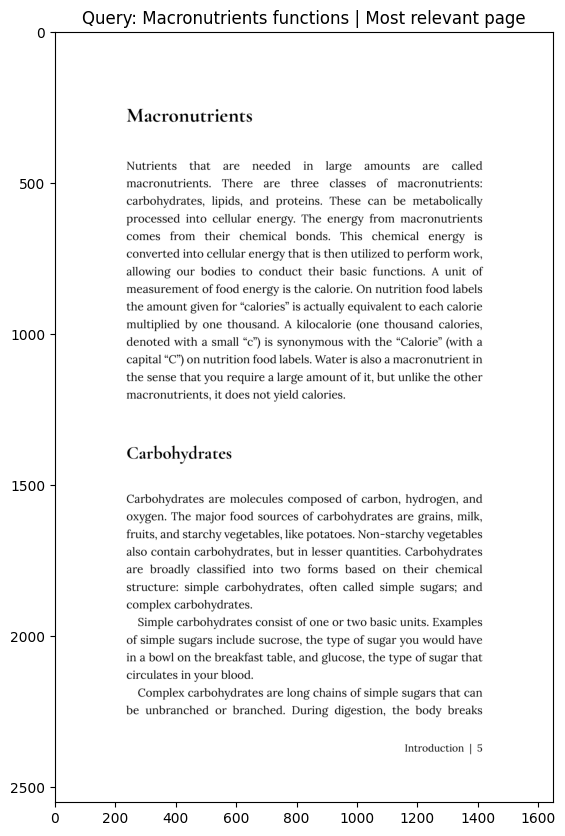

In [41]:
import fitz
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(46)
print(page)
## get the image of the page
img = page.get_pixmap(dpi=300)
doc.close()
img_array = np.frombuffer(img.samples_mv,dtype=np.uint8).reshape((img.h,img.w,img.n))
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant page")